In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk

In [2]:
df = pd.read_csv("news_sentiment_analysis.csv")
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


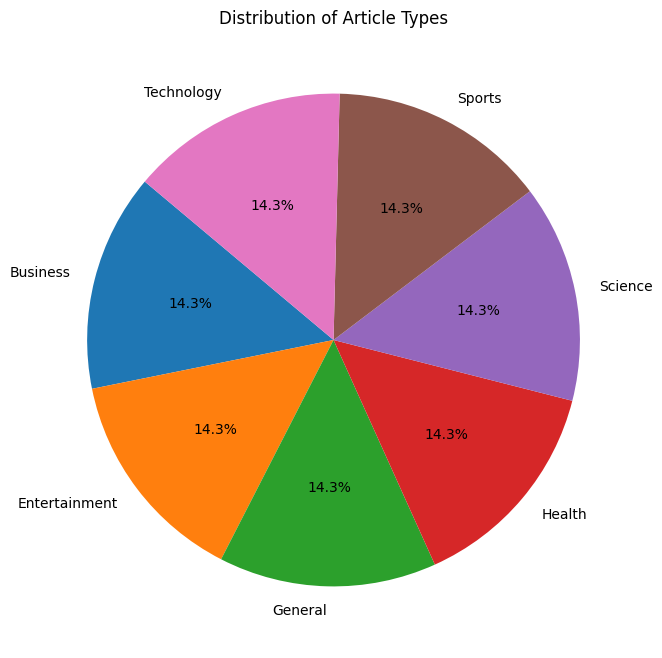

In [5]:
type_counts = df['Type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Article Types')
plt.show()

In [3]:
df['Author'].fillna('Unknown', inplace=True)

/tmp/ipykernel_8753/5555822.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Author'].fillna('Unknown', inplace=True)


In [4]:
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,Unknown,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,Unknown,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,Unknown,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


#### 1. Naive Bayes

1. Replace NaN values in the 'Author' column with 'Unknown'.
2. Combine the 'Title' and 'Description' columns into a single 'text' column for feature extraction.
3. Define the features (X) as the combined text and the target variable (y) as the 'Type' column.
4. Split the dataset into training and testing sets with 80% for training and 20% for testing.
5. Define a parameter grid for hyperparameter tuning of the TF-IDF Vectorizer and Multinomial Naive Bayes classifier.
6. Create a pipeline that includes the TF-IDF Vectorizer and Multinomial Naive Bayes classifier.
7. Use GridSearchCV to find the best hyperparameters using 5-fold cross-validation.
8. Train the model with the best parameters on the training data.
9. Make predictions on the test data.

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords

df['text'] = df['Title'] + ' ' + df['Description']


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type,text
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business,pine view high teacher wins best state award b...
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business,businesses face financial strain amid liquidit...
2,4-traders,Unknown,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business,musk donates super pac working elect trump blo...
3,4-traders,Unknown,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business,us ftc issues warning franchisors unfair busin...
4,PLANET,Unknown,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business,rooftop solars dark side 45 million households...


In [8]:
X = df['text']
y = df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'tfidfvectorizer__max_df': [0.75, 1.0],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': [0.1, 1.0]
}

pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Beste Parameter:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Beste Parameter: {'multinomialnb__alpha': 1.0, 'tfidfvectorizer__max_df': 0.75, 'tfidfvectorizer__ngram_range': (1, 2)}
Accuracy: 0.77


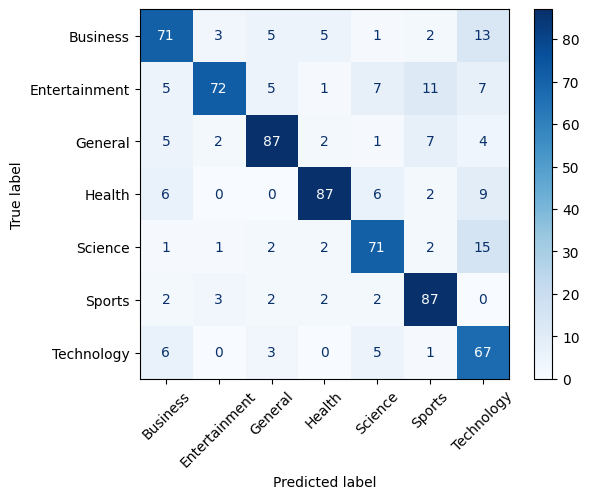

In [9]:
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

### Examples for wrong predictions

In [10]:
misclassified_indices = np.where(y_pred != y_test)[0]

random_indices = np.random.choice(misclassified_indices, size=3, replace=False)

for index in random_indices:
    print(f"Text: {X_test.iloc[index]}")
    print(f"True Label: {y_test.iloc[index]}")
    print(f"Predicted Label: {y_pred[index]}")
    print("-" * 80)

Text: ConnectM Completes Business Combination with Monterey Capital Acquisition Corporation ~ ConnectM Common Stock to Trade on Nasdaq on July 15, 2024 Under Ticker "CNTM" ~ MARLBOROUGH, MA / ACCESSWIRE / July 12, 2024 / ConnectM Technology Solutions, Inc. ("ConnectM"), a technology compa...
True Label: Technology
Predicted Label: Business
--------------------------------------------------------------------------------
Text: AEG Supports Diverse Suppliers Through Vendor Stewardship Program NORTHAMPTON, MA / ACCESSWIRE / July 18, 2024 / As part of its supplier diversity program, AEG, a global leader in sports and live entertainment, is helping minority-owned businesses obtain vendor c...
True Label: Sports
Predicted Label: Entertainment
--------------------------------------------------------------------------------
Text: Grant access to immunization staff, FCTA urges gated estate residents Tribune OnlineGrant access to immunization staff, FCTA urges gated estate residentsThe Federal Ca

### 2. Bert


1. Define a custom dataset class `TextDataset`:
   - The class initializes with texts, labels, tokenizer, and max_len.
   - The `__getitem__` method tokenizes the text, ensuring padding and truncation to max_len, and returns input IDs, attention mask, and labels.

2. Replace NaN values in the 'Author' column with 'Unknown'.

3. Combine 'Title' and 'Description' columns into a single 'text' column for feature extraction.

4. Encode the labels using `LabelEncoder`.

5. Define the tokenizer and model using BERT from Hugging Face.

6. Set the maximum sequence length (`max_len`) for tokenization.

7. Prepare the dataset and dataloaders:
   - Convert the DataFrame columns to numpy arrays and create a `TextDataset` instance.
   - Split the dataset into training and testing sets.
   - Create DataLoader instances for training and testing.

8. Define the optimizer (`AdamW`) and loss function (`CrossEntropyLoss`).

9. Training loop:
    - Set the device to GPU if available.
    - Train the model for a specified number of epochs.
    - Calculate and print the training loss and accuracy for each epoch.

10. Evaluation loop:
    - Evaluate the model on the test set.
    - Calculate and print the test loss and accuracy.

In [11]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os


In [12]:
df = pd.read_csv("news_sentiment_analysis.csv")
df.head()

,Source,Author,Title,Description,URL,Published At,Sentiment,Type
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business


In [13]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',  # Padding to max length
            truncation=True,  # Truncate to max length
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [14]:
df['Author'].fillna('Unknown', inplace=True)

df['text'] = df['Title'] + ' ' + df['Description']

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Type'])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['label'].unique()))

dataset = TextDataset(
    texts=df['text'].to_numpy(),
    labels=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model = model.to(device)

cuda


In [16]:
for epoch in range(3):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions.double() / len(train_loader.dataset)

    print(f'Epoch {epoch + 1}/{3}')
    print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')

Epoch 1/3
Train loss: 0.7670, Train accuracy: 0.7564
Epoch 2/3
Train loss: 0.2216, Train accuracy: 0.9421
Epoch 3/3
Train loss: 0.1651, Train accuracy: 0.9532


In [17]:
model_save_path = "Bert_type_classifier"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

model_save_file = os.path.join(model_save_path, "model_weights.pth")
torch.save(model.state_dict(), model_save_file)
tokenizer.save_pretrained(model_save_path)

('Bert_type_classifier/tokenizer_config.json',
 'Bert_type_classifier/special_tokens_map.json',
 'Bert_type_classifier/vocab.txt',
 'Bert_type_classifier/added_tokens.json')

In [18]:
model.eval()
total_loss = 0
correct_predictions = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = total_loss / len(test_loader)
test_accuracy = correct_predictions.double() / len(test_loader.dataset)

print(f'Test loss: {avg_test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.2169, Test accuracy: 0.9414


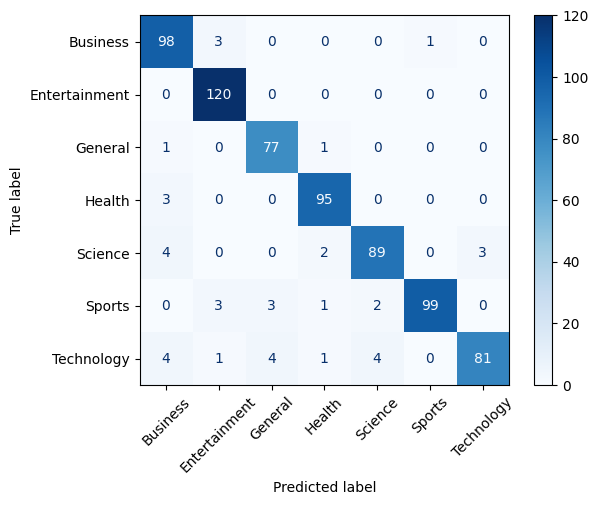

In [19]:
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

In [20]:
source_file_path = '/content/Bert_type_classifier'
destination_file_path = '/content/drive/My Drive/'


!cp -r $source_file_path $destination_file_path

print(f"File copied to {destination_file_path}")

cp: target 'Drive/' is not a directory
File copied to /content/drive/My Drive/


## 3. Autogluon

In [ ]:
!pip install autogluon

In [1]:
from autogluon.tabular import TabularPredictor, TabularDataset
import pandas as pd
from sklearn.model_selection import train_test_split

data=TabularDataset('news_sentiment_analysis.csv')

In [2]:
data = data.drop(columns=['Source'])
data = data.drop(columns=['Author'])
data = data.drop(columns=['Title'])
data = data.drop(columns=['URL'])
data = data.drop(columns=['Published At'])
data = data.drop(columns=['Sentiment'])

In [3]:
data

,Description,Type
0,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",Business
1,"Harare, Zimbabwe – Local businesses are grappl...",Business
2,(marketscreener.com) Billionaire Elon Musk has...,Business
3,(marketscreener.com) A U.S. trade regulator on...,Business
4,4.5 million households in the U.S. have solar ...,Business
...,...,...
3495,QRG Capital Management Inc. increased its stak...,Technology
3496,QRG Capital Management Inc. bought a new posit...,Technology
3497,QRG Capital Management Inc. boosted its stake ...,Technology
3498,"WESTFORD, Mass., July 18, 2024 /PRNewswire/ --...",Technology


In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
predictor=TabularPredictor(label='Type').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20240807_191648"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #44-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun  7 15:10:09 UTC 2024
CPU Count:          8
Memory Avail:       8.58 GB / 15.34 GB (56.0%)
Disk Space Avail:   313.84 GB / 467.35 GB (67.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quali

In [6]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.902,accuracy,0.028503,2.466076,0.028503,2.466076,1,True,5
1,WeightedEnsemble_L2,0.902,accuracy,0.029159,2.563985,0.000656,0.097909,2,True,14
2,LightGBMLarge,0.902,accuracy,0.133205,6.456386,0.133205,6.456386,1,True,13
3,XGBoost,0.898,accuracy,0.008178,2.148893,0.008178,2.148893,1,True,11
4,LightGBMXT,0.894,accuracy,0.009298,1.911654,0.009298,1.911654,1,True,4
5,RandomForestEntr,0.886,accuracy,0.033726,0.573634,0.033726,0.573634,1,True,7
6,CatBoost,0.884,accuracy,0.014928,8.280191,0.014928,8.280191,1,True,8
7,RandomForestGini,0.882,accuracy,0.033798,0.649066,0.033798,0.649066,1,True,6
8,ExtraTreesGini,0.870,accuracy,0.033768,0.795074,0.033768,0.795074,1,True,9
9,ExtraTreesEntr,0.850,accuracy,0.034105,0.709476,0.034105,0.709476,1,True,10


In [7]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              LightGBM      0.902    accuracy       0.028503  2.466076                0.028503           2.466076            1       True          5
1   WeightedEnsemble_L2      0.902    accuracy       0.029159  2.563985                0.000656           0.097909            2       True         14
2         LightGBMLarge      0.902    accuracy       0.133205  6.456386                0.133205           6.456386            1       True         13
3               XGBoost      0.898    accuracy       0.008178  2.148893                0.008178           2.148893            1       True         11
4            LightGBMXT      0.894    accuracy       0.009298  1.911654                0.009298           1.911654            1       True          4
5      RandomForestEntr      0.886    

/home/nico/Documents/BHT/Data_Science_Workflow/sentAnalyse/lib/python3.11/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestGini': 'RFModel',
  'RandomForestEntr': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesGini': 'XTModel',
  'ExtraTreesEntr': 'XTModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.422,
  'KNeighborsDist': 0.572,
  'NeuralNetFastAI': 0.438,
  'LightGBMXT': 0.894,
  'LightGBM': 0.902,
  'RandomForestGini': 0.882,
  'RandomForestEntr': 0.886,
  'CatBoost': 0.884,
  'ExtraTreesGini': 0.87,
  'ExtraTreesEntr': 0.85,
  'XGBoost': 0.898,
  'NeuralNetTorch': 0.442,
  'LightGBMLarge': 0.902,
  'WeightedEnsemble_L2': 0.902},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeighborsUnif'],
  'KNeighborsDist': ['KNe

In [8]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 1 features using 2800 rows with 5 shuffle sets...
	5.59s	= Expected runtime (1.12s per shuffle set)
	3.07s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Description,0.820643,0.007911,1.036360e-09,5,0.836932,0.804353


In [9]:
predictor.path

'AutogluonModels/ag-20240807_191648'

In [10]:
predictor_new=TabularPredictor.load('AutogluonModels/ag-20240807_191648')

In [11]:
predictor_new.evaluate(test_data)

{'accuracy': 0.8814285714285715,
 'balanced_accuracy': 0.880944793286066,
 'mcc': 0.8616343797415537}

In [12]:
predictions = predictor_new.predict(test_data)
print(predictions)

1650          General
2456           Health
2232    Entertainment
1945           Sports
309            Health
            ...      
3127           Health
744          Business
631          Business
1557           Sports
2213    Entertainment
Name: Type, Length: 700, dtype: object


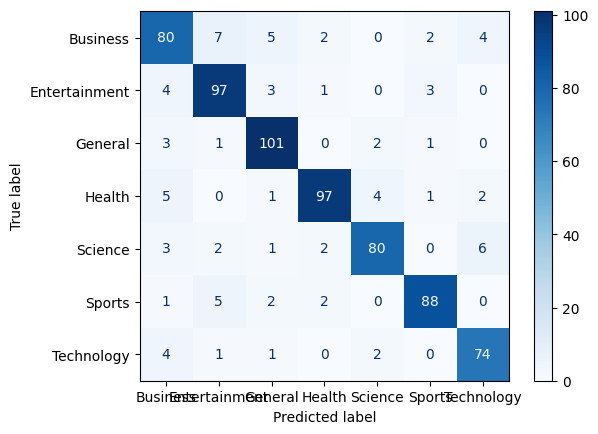

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label = 'Type'

true_labels = test_data[label]
cm = confusion_matrix(true_labels, predictions, labels=predictor.class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()